<a name="top"> <h1>2.2. GLM Model</h1> <a>

<p>Payments Fraud Practice<br />
<strong>Aprendizaje Autom&aacute;tico</strong><br />
<strong>Master Universitario en Ciencia de Datos</strong></p>

<p>&nbsp;</p>

<p style="text-align:right">Antonio Nogués Podadera (<em>antonio.nogues@cunef.edu</em>)</p>
<p style="text-align:right">V&iacute;ctor Viloria V&aacute;zquez (<em>victor.viloria@cunef.edu</em>)</p>

<hr style="border:1px solid gray">

### Estructura

[0. Introducción](#introduccion) 


[1. Importación de librerias y funciones](#librerias) 


[2. Carga de datos](#datos) 

[3. Creación del modelo](#creacion) 

   
[4. Optimización del modelo](#optimizacion) 

   
[5. Predicción del modelo](#prediccion)

[6. Evaluación de las métricas del modelo](#metricas)

   - Matriz de confusión
   - Métricas: Accuracy, Recall, Precision, F1 y F2 score
   - Curva ROC

<hr style="border:1px solid gray">

# <a name="introduccion"> 0. Introducción <a> 


En este documento, nos centraremos en la creación de un **Modelo Lineal generalizado (GLM)**.

Este modelo se emplea para predecir valores de una variable continua (Y) como una combinación lineal de las variables predictoras (X). **Un modelo GLM está compuesto por tres partes**:

- **Una componente aleatoria**. Identifica la variable respuesta y su distribución de probabilidad.

- **Una componente sistemática**. Especifica las variables explicativas (independientes o predictoras) utilizadas en la función predictora lineal.

- **Una función link**. Es una función del valor esperado de Y , E(Y ), como una combinación lineal de las variables predictoras

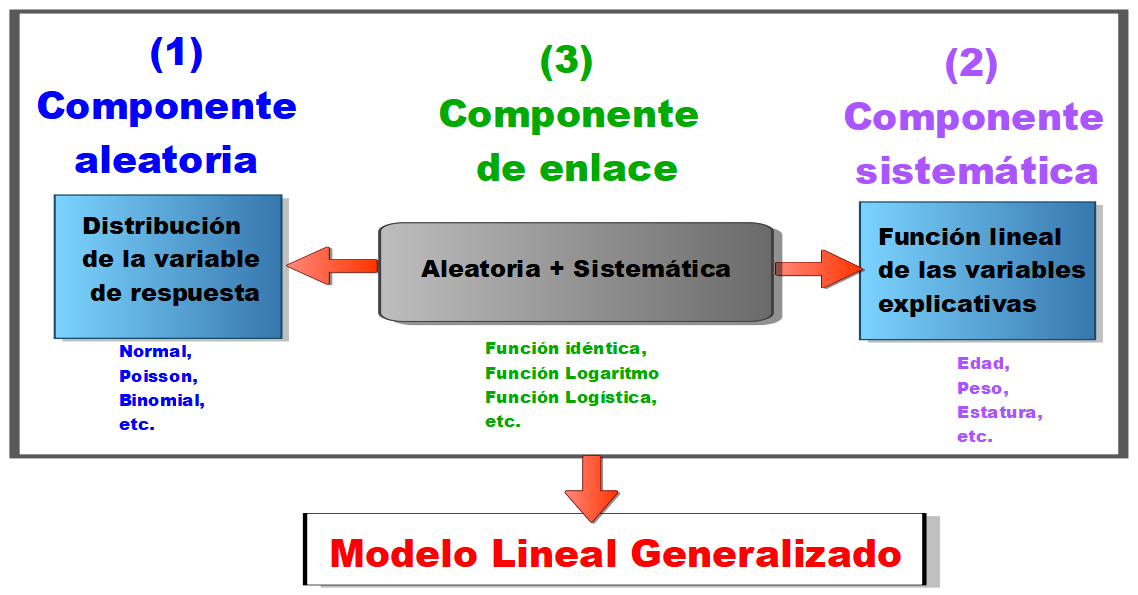

Una vez creado el modelo, procederemos a optimizarlo con los valores de train y predecir los valores de validación, para posteriormente análizar sus métricas.


# <a name="librerias"> 1. Importación de librerias y funciones <a> 


Importamos las librerias necesarias para la creación y optimización del modelo lineal generalizado (GLM):

In [15]:
# Import basic libraries.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

# Import sklearn metrics.

from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, roc_curve, fbeta_score, roc_auc_score, plot_confusion_matrix
import scikitplot as skplt

# Import sklearn models and pipeline.

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression



Importamos las funciones a utilizar:

In [2]:
# Import the functions used in the notebook.

from aux_functions import load_model, save_model

Cargamos el pickle de preprocesado, para su posterior uso:

In [3]:
# Import the preprocessor.

preprocessor = load_model('../models/preprocessor.pickle')

# <a name="datos"> 2. Carga de datos <a> 

En primer lugar procederemos a cargar los datos de train y validación que insertaremos dentro del modelo para su optimización y predicción.

In [4]:
# Load the train dataset separated by other variables and target. Taking into account that the first column is the index.

x_train = pd.read_csv("../data/processed/x_train.csv",index_col=0 )
y_train = pd.read_csv("../data/processed/y_train.csv",index_col=0 )

# Load the validation dataset separated by other variables and target. Taking into account that the first column is the index.

x_val = pd.read_csv("../data/processed/x_val.csv",index_col=0 )
y_val = pd.read_csv("../data/processed/y_val.csv",index_col=0 )

# <a name="creacion"> 3. Creación del modelo <a> 

Para la creación del modelo, **utilizaremos un modelo de regresión logística** dado que es un GLM donde la distribución de probabilidad puede ser Bernoulli o Binomial. Por lo tanto la estimación de los parámetros y los contrastes de hipótesis utilizan la teoría desarrollada para los GLM's.

Creamos un Pipeline que junte el preprocesado y el modelo de regresión para ejecutarlo en el orden mencionado.

Designaremos una penalización de tipo L2 (Ridge), dado que en el documento `04_LogisticRegressionLasso` realizaremoss una regresión con un modelo L1 (Lasso). 

In [5]:
# Designate the hyperparameters.

penalty = 'l2'
n_jobs = -1
random_state = 12345

# Create a pipeline that applies a preprocess of the data and then the LogisticRegression model.

glm_model = Pipeline([
    ('preprocessor', preprocessor),
    ('clasificador',  LogisticRegression(penalty=penalty,n_jobs=n_jobs, random_state=random_state)
    )
])


# <a name="optimizacion"> 4. Optimización del modelo <a> 

Optimizamos el modelo a través del pipeline creado anteriormente, para ello introduciremos los valores de train.

In [6]:
# Optimization of the Regression model with the train set: input and target data. 

glm_model.fit(x_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='unknow',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['type', 'gender', 'device',
                                                   'zone', 'security_alert',
                                                   'nameDest', 'nameOrig',
                                                   'nameDest']),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['step', 'amount',
                                                   'connection_time',
                                                   'oldbalanceOrg', 'age',
                                                   'newbalanceOrig',
                                                   'user_number',
                                                   'oldbalanceDest',
                                                   'newbalanceDest'])])),
                ('clasificador',
                 LogisticRegression(n_jobs=-1, random_state=12345))])

Una vez optimizado el modelo GLM, con el set de train, procedemos a guardarlo en un pickle para que no se tenga que volver a computarlo en un futuro, por si quisieramos usarlo.

In [10]:
# Save the backup of the Regression optimization as a pickle file.

save_model(glm_model,'../models/glm_model.pickle')

**Para evitar optimizar de nuevo el modelo, ejecutar a partir de la celda que aparece a continuación.**

In [11]:
# Load the GLM model already fitted in /models.

glm_model = load_model('../models/glm_model.pickle')


# <a name="prediccion"> 5. Predicción del modelo <a> 

Una vez realizada la optimización del modelo de regresión lineal, procederemos a predecir el set de validación, sus valores y probabilidades. Posteriormente analizaremos las métricas para ver como se comporta el modelo y sus scores.

In [12]:
# Predict the target value of the validation set.

predictions = glm_model.predict(x_val)

# Predict the probabilities of the target value for the validation set.

predict_probabilities = glm_model.predict_proba(x_val)

# <a name="metricas"> 6. Evaluación de las métricas del modelo <a> 

En este aparatado procederemos a análizar las métricas obtenidas. En el caso de que se quiera consultar la definición de cada una de ellas, se pueden encontrar en el documento `02_DummyModel`.

### 6.1. Matriz de confusión

Confusion matrix, without normalization
[[196393      1]
 [   149     65]]
Normalized confusion matrix
[[9.99994908e-01 5.09180525e-06]
 [6.96261682e-01 3.03738318e-01]]


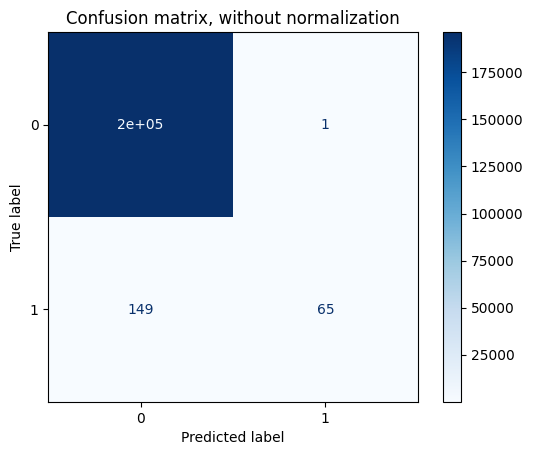

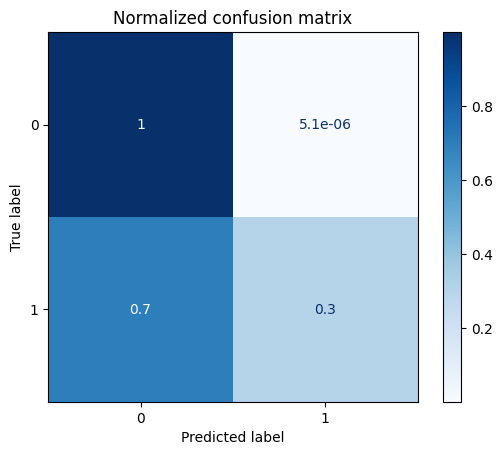

In [14]:
# List with the titles and parameters

titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]

# Plot the confusion matrix

for title, normalize in titles_options:
    disp = plot_confusion_matrix(glm_model, x_val, y_val,
                                 # display_labels=ytest,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

Como podemos observar para el set de validación, la **predicción de los positivos reales unicamente es de un 30%, mientras que el 70% son falsos negativos**. Esta predicción no es muy acertada dado que pasa por alto bastantes transacciones fraudulentas.

### 6.2. Métricas: Accuracy, Recall, Precision, F1 y F2 score

In [18]:
# Print the general metrics.

print(classification_report(y_val, predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    196394
           1       0.98      0.30      0.46       214

    accuracy                           1.00    196608
   macro avg       0.99      0.65      0.73    196608
weighted avg       1.00      1.00      1.00    196608



In [19]:
# Print the F2 score.

print('F2 score is ' +str(fbeta_score(y_val, predictions, average='binary', beta=2)))

# Model Accuracy

print("Accuracy:",metrics.accuracy_score(y_val, predictions))

F2 score is 0.35249457700650755
Accuracy: 0.999237060546875


Como ya comentamos en el documento `02_DummyModel`, nuestro dataset se caracteriza por tener un desbalanceo muy grande, es por ello que el análisis de las métricas de accuracy y precisión siempre van a ser muy elevadas, sin embargo, no reflejan la realidad predictora de nuestro modelo. Por lo que nos centraremos principalmente en las métricas F2-score y AUC .

- El modelo nos calcula un **Recall de 0.65**, dado que el modelo no llega a detectar correctamente aquellas transacciones que son fraude o no.

- El modelo nos calcula un **F2 score de 0.35**, un valor mayor que en el modelo Dummy, sin embargo, sigue siendo un valor muy bajo como para realizar predicciones óptimas. 

### 6.3. Curva ROC

Para evaluar nuestro modelo, la representaremos graficamente para deducir que tan bueno es el modelo.

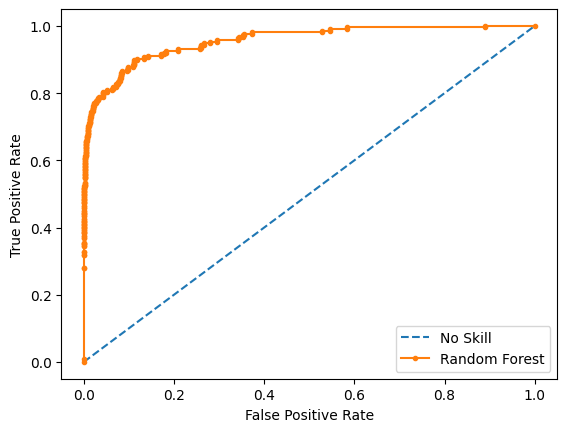

The Compute Area Under the Receiver Operating Characteristic is 0.9558578554515484


In [16]:
# Keep probabilities for the positive outcome only
yhat = predict_probabilities[:, 1]
# Calculate roc curves
fpr, tpr, thresholds = roc_curve(y_val, yhat)
# Plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Random Forest')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# Show the plot
plt.show()

# Display the ROC AUC.

print('The Compute Area Under the Receiver Operating Characteristic is '+ str(roc_auc_score(y_val,yhat)))

Una vez representada la **curva ROC**, la cual tiene un área bajo la curva con **valor de 0.95**, observamos como nuestro modelo aparentemente tiene un alto nivel de discriminación, sin emabargo, **nos interesa penalizar aquellas predicciones que han sido fraudulentas y las ha considerado correctas**.

Por lo que a partir de este momento, **consideraremos la métrica F2 como la principal para basarnos si nuestros modelos son certeros o no**.

[Ir arriba del documento](#top)